In [14]:
import matplotlib.pyplot as plt
# plt.rc('text', usetex=True)
plt.rcdefaults()

import seaborn as sns

import numpy as np
from sklearn.metrics import pairwise_distances
from sklearn_extra.cluster import KMedoids
import sys
sys.path.append('..')

import time_toolbox as ttb

herz_day = 0.04166667

Link for data download:

https://www.timeseriesclassification.com/aeon-toolkit/ItalyPowerDemand.zip

In [2]:
data_test, y_te = ttb.read_data('data/ItalyPowerDemand/ItalyPowerDemand_TEST.txt')
data_train, y_tr = ttb.read_data('data/ItalyPowerDemand/ItalyPowerDemand_TRAIN.txt')

data_stack = np.vstack((data_train, data_test))
y = np.hstack((y_tr, y_te))

# we use the split as in the paper by Kim et al 2021 - Dynamic Clustering in Federated Learning. They use 70% of the data to train the models
data_70 = int(np.ceil(data_stack.shape[0] * 0.7))
np.random.seed(42)
data_70_sampling = np.random.choice(data_stack.shape[0], data_70, replace=False)
# we obtain the subset
data_stack = data_stack[data_70_sampling]
y = y[data_70_sampling]

# the number of clusters to be identified in the dataset
k_clusters = 2

print(data_stack.shape, y.shape)

(768, 24) (768,)


# Model benchmarks

In [3]:
print("Compute gaussian mixture model...")

avg_purity, std_purity = ttb.purity_clustering(y, k_clusters, data_stack, _n_init=5, _method='gmm')

print("Purity of GMM clustering:", round(avg_purity * 100, 2), "+/-", round(std_purity * 100, 2))

Compute gaussian mixture model...
Purity of GMM clustering: 53.78 +/- 0.0


In [4]:
print("Compute hierarchical clustering...")

avg_purity, std_purity = ttb.purity_clustering(y, k_clusters, data_stack, _n_init=5, _method='hierarchical')

print("Purity of hierarchical clustering:", round(avg_purity * 100, 2), "+/-", round(std_purity * 100, 2))

Compute hierarchical clustering...
Purity of hierarchical clustering: 51.43 +/- 0.0


# Wasserstein-based clustering

In [5]:
norm_data = ttb.normalize_data(data_stack)
# we perform PCA on norm_data
norm_data_pca = ttb.reduce_variance(norm_data, _variance=0.85)

# we compute the Fourier transform
X, support = ttb.get_fourier(norm_data_pca, _welch=False)

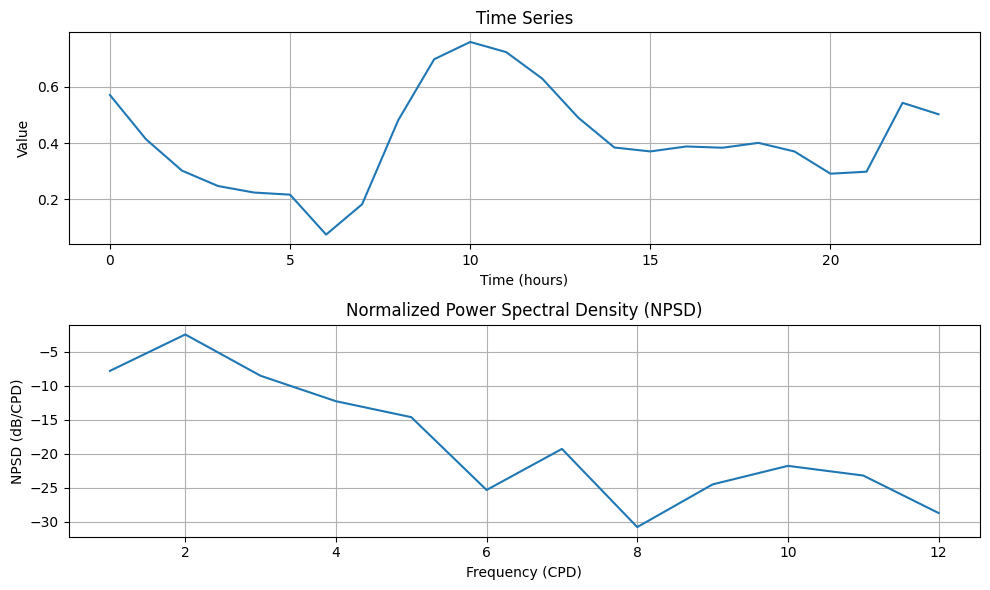

In [6]:
# we plot the time series and its normalized power spectral density
time_series_index = 717
fig, ax = plt.subplots(2, 1, figsize=(10, 6))

# Plot the time series
ax[0].plot(norm_data_pca[time_series_index, :])
ax[0].set_title('Time Series')
ax[0].set_xlabel('Time (hours)')
ax[0].set_ylabel('Value')
ax[0].grid()

# Plot the normalized power spectral density
ax[1].plot(support/herz_day, 10 * np.log10(X[time_series_index, :]))
ax[1].set_title('Normalized Power Spectral Density (NPSD)')
ax[1].set_xlabel('Frequency (CPD)')
ax[1].set_ylabel('NPSD (dB/CPD)')
ax[1].grid()

plt.tight_layout()
plt.show()

In [7]:
Sinv, q_Sinvs = ttb.get_inverse_histograms(X, support)

In [8]:
sq_dist = pairwise_distances(q_Sinvs, metric='sqeuclidean')
mask = sq_dist > 0
indices = np.where(mask)
idx_flat = np.argmax(sq_dist[mask])
i_mu1, i_mu2 = indices[0][idx_flat], indices[1][idx_flat]
print((i_mu1, i_mu2))

(650, 717)


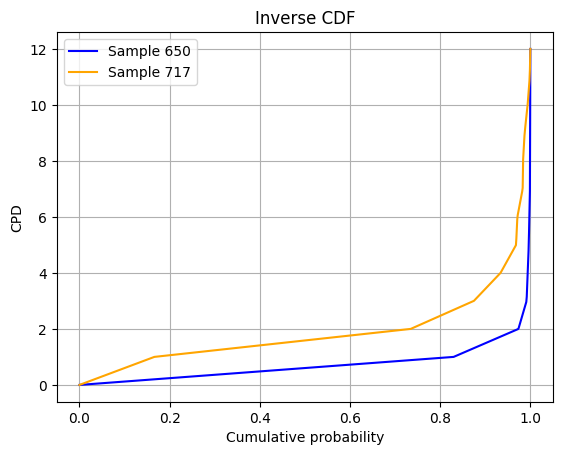

In [9]:
# we plot q_Sinv
plt.plot(Sinv, q_Sinvs[i_mu1]/herz_day, label=f'Sample {i_mu1}', color='blue')
plt.plot(Sinv, q_Sinvs[i_mu2]/herz_day, label=f'Sample {i_mu2}', color='orange')
plt.xlabel('Cumulative probability')
plt.ylabel('CPD')
plt.title('Inverse CDF')
plt.grid()
plt.legend(loc='upper left')
plt.show()

# Kernel clustering

In [10]:
# we find the g_wass_max parameter that maximizes the off diagonal variance
gammas, dispersions = ttb.optimal_dispersion_kernel(np.sqrt(sq_dist), test_range = (-4, 4, 100)) 

g_wass_max = gammas[np.argmax(dispersions)]
print("Maximum dispersion = ", dispersions[np.argmax(dispersions)], " at gamma = ", g_wass_max)

Maximum dispersion =  0.10843972  at gamma =  0.6060606


In [11]:
bayes_iter, bayes_init = 20, 20 # the number of iterations and initial points for the optimizer
eps = 1.0

print("\n-------------------------------------------\n")
print("Kaiser criterion for component selection\n")

df_results, execution_info = ttb.bayes_optimize_italy(g_wass_max, sq_dist, eps, bayes_init, bayes_iter, k_clusters)

g_wass = df_results['gamma_wasserstein'][0] # we take the best gamma according to the target value

phi_wass, variance_retained = ttb.italy_kernel_map(sq_dist, g_wass)

avg_purity, std_purity = ttb.purity_clustering(y, k_clusters, phi_wass)
print("\n-------------------------------------------\n")
print("Number of components: ", phi_wass.shape[1], "\nRetained variance: ", round(variance_retained * 100, 2), "%")
print("\nPurity of kernel clustering:", round(avg_purity * 100, 2), "+/-", round(std_purity * 100, 2))


-------------------------------------------

Kaiser criterion for component selection

Bayesian optimization for kernel parameters
Random point iterations:


100%|██████████| 20/20 [00:33<00:00,  1.69s/it]


Bayes point iterations:


100%|██████████| 20/20 [00:37<00:00,  1.89s/it]


Total execution time:  71.56496071815491

-------------------------------------------

Number of components:  16 
Retained variance:  99.01 %

Purity of kernel clustering: 77.66 +/- 1.34


In [88]:
# execution time per iteration
exec_times = np.array(list(execution_info.values()))
print("Min execution time:", round(np.min(exec_times),2))
print("Std. execution time:", round(np.std(exec_times),2))
print("Avg. execution time:", round(np.mean(exec_times),2))
print("Max execution time:", round(np.max(exec_times),2))

Min execution time: 0.7
Std. execution time: 0.21
Avg. execution time: 1.78
Max execution time: 2.12


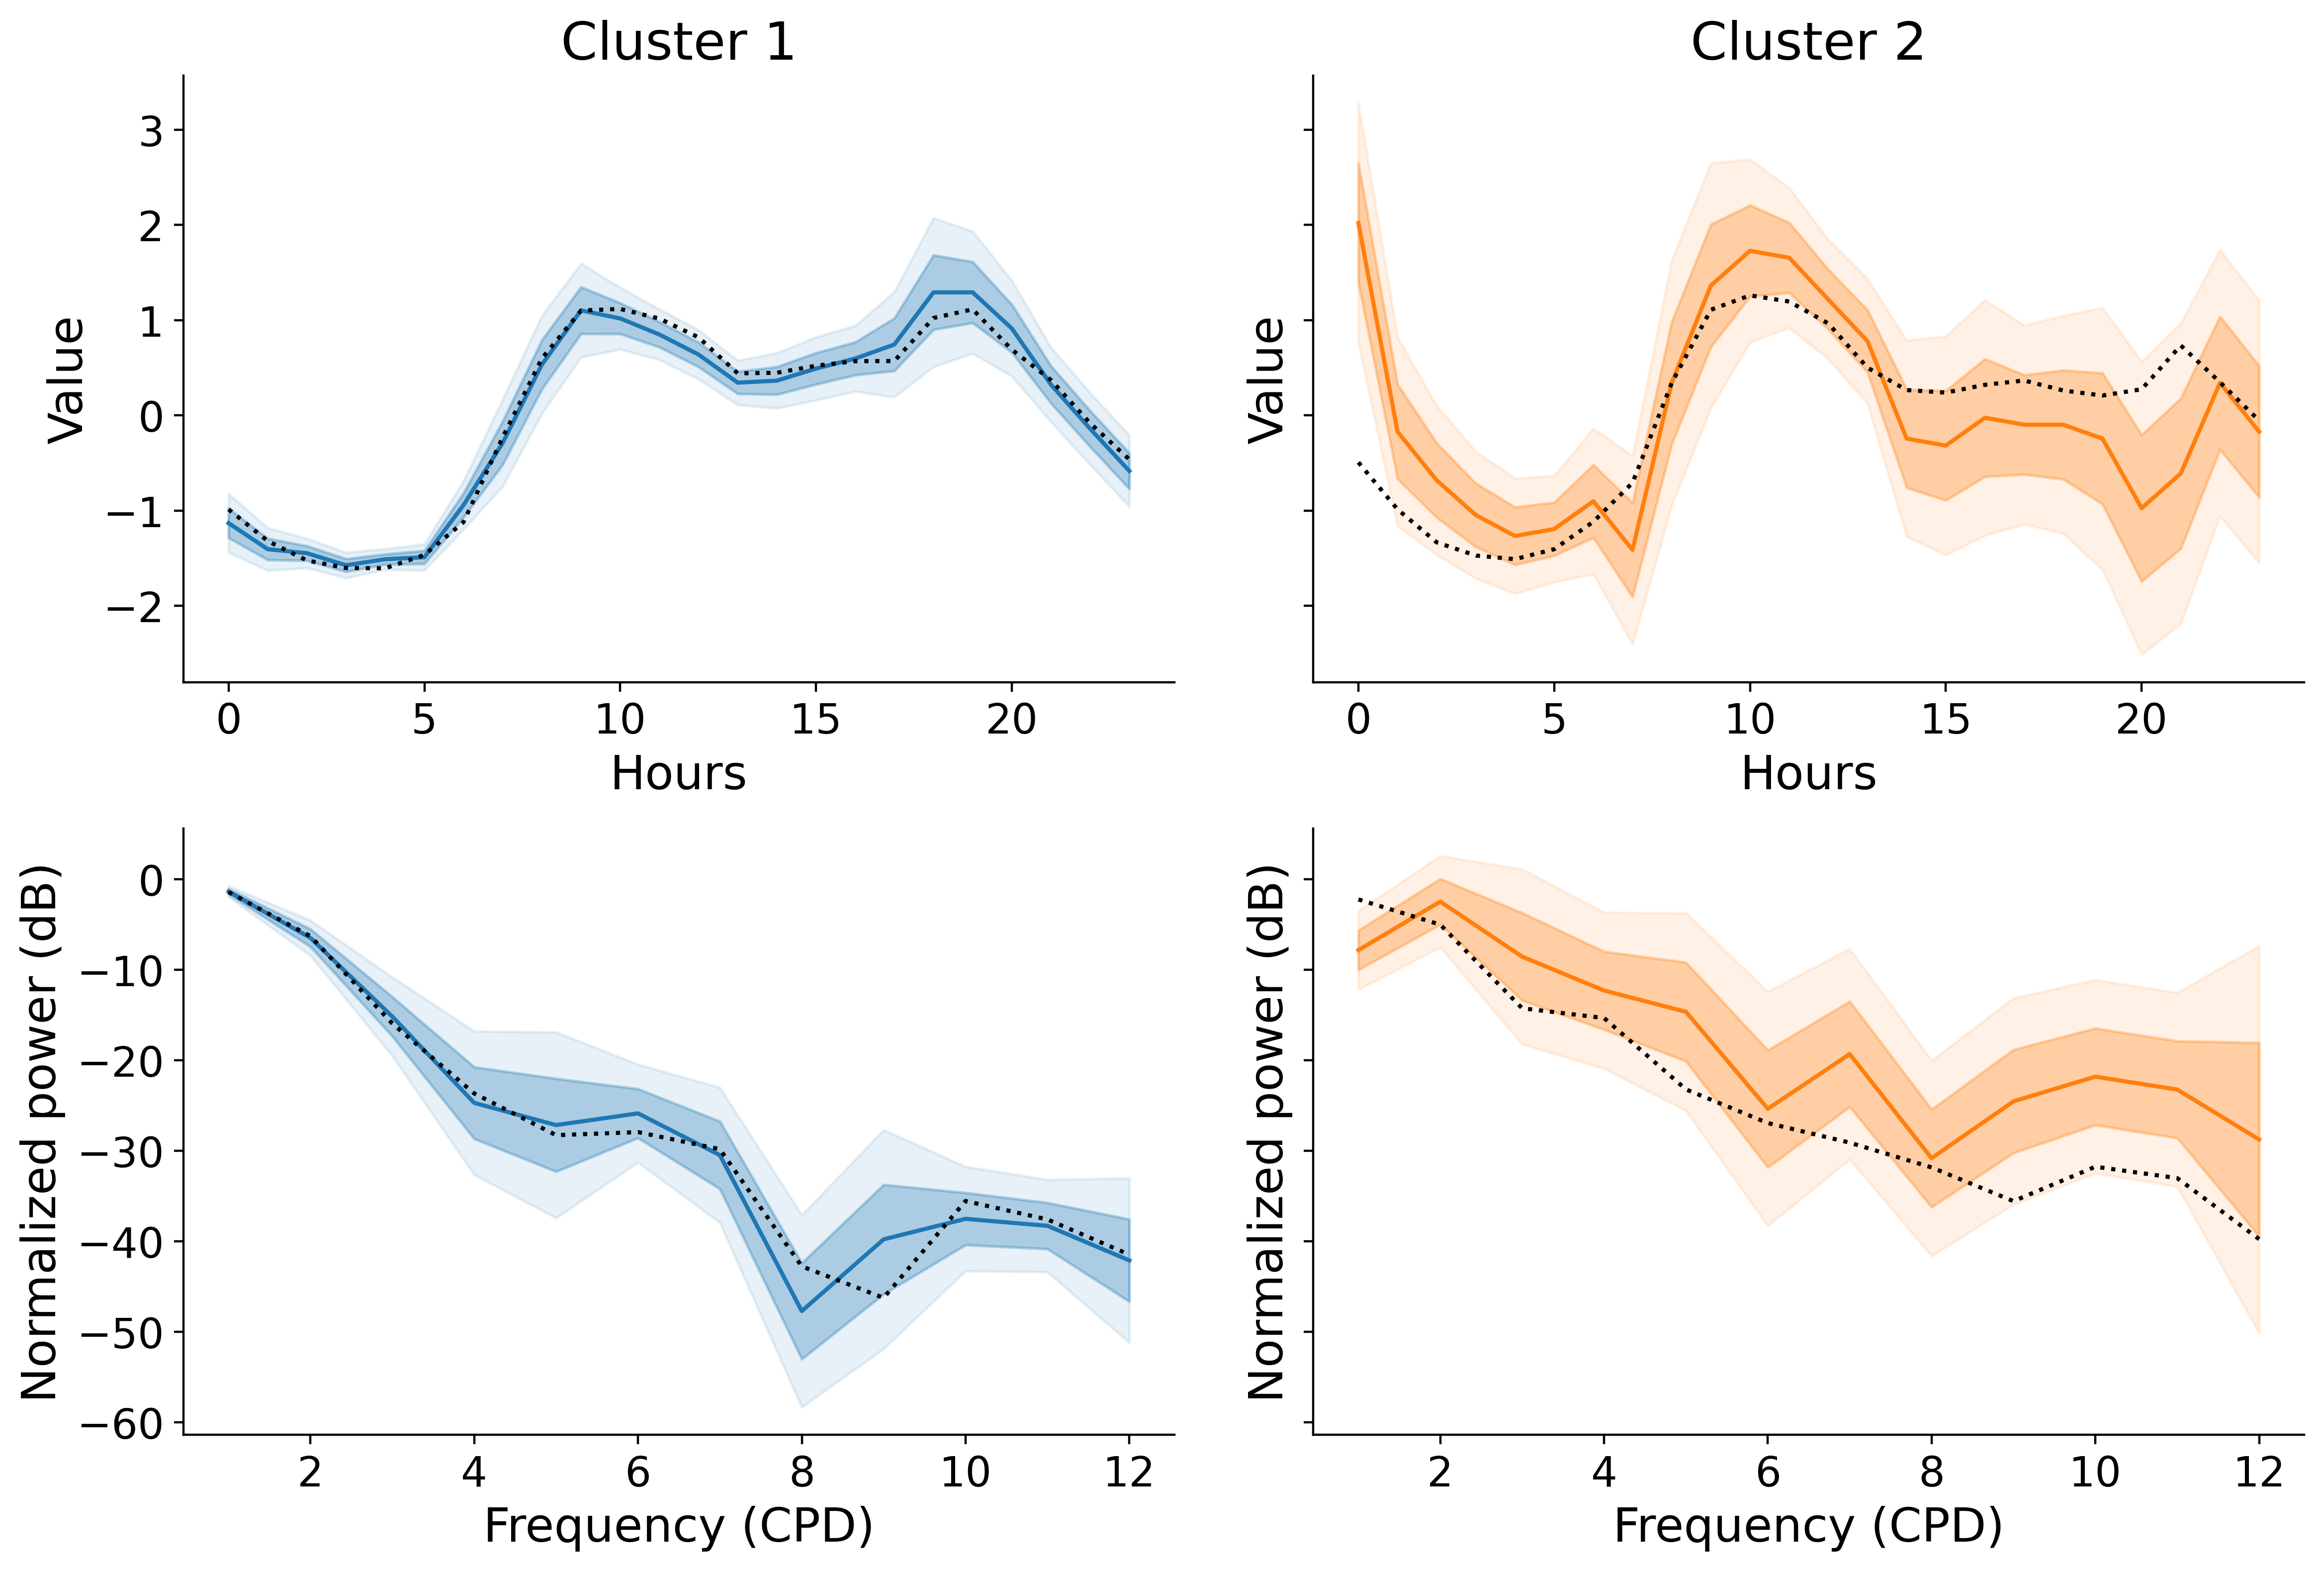

Cluster sizes: [0.39322917 0.60677083]


In [15]:
kernel_kmedoids = KMedoids(n_clusters=k_clusters, random_state=0, init='k-medoids++', method='alternate').fit(phi_wass)

# we plot the time series and its normalized power spectral density
fig, ax = plt.subplots(2, 2, figsize=(12, 8), sharey='row', dpi=400)
# we get colors from tab10
colors = sns.color_palette()

for i, time_series in enumerate(kernel_kmedoids.medoid_indices_):
    # Percentiles for shading
    time_std = np.std(data_stack[np.where(kernel_kmedoids.labels_ == i)[0], :], axis=0)
    freq_db = 10 * np.log10(X[time_series, :])
    freq_std = np.std(10 * np.log10(X[np.where(kernel_kmedoids.labels_ == i)[0], :]), axis=0)
    time_median = np.median(data_stack[np.where(kernel_kmedoids.labels_ == i)[0], :], axis=0)
    freq_median = np.median(10 * np.log10(X[np.where(kernel_kmedoids.labels_ == i)[0], :]), axis=0)
    time_75 = np.percentile(data_stack[np.where(kernel_kmedoids.labels_ == i)[0], :], 75, axis=0)
    time_p25 = np.percentile(data_stack[np.where(kernel_kmedoids.labels_ == i)[0], :], 25, axis=0)
    freq_75 = np.percentile(10 * np.log10(X[np.where(kernel_kmedoids.labels_ == i)[0], :]), 75, axis=0)
    freq_p25 = np.percentile(10 * np.log10(X[np.where(kernel_kmedoids.labels_ == i)[0], :]), 25, axis=0)

    # Plot the time series in row 0, column i
    ax[0, i].plot(data_stack[time_series, :], color=colors[i])
    ax[0, i].plot(time_median, color='black', linestyle='dotted', label='Median')
    ax[0, i].fill_between(np.arange(data_stack.shape[1]), data_stack[time_series, :] - 2 * time_std,
                           data_stack[time_series, :] + 2 * time_std, color=colors[i], alpha=0.1)
    ax[0, i].fill_between(np.arange(data_stack.shape[1]), data_stack[time_series, :] - time_std,
                           data_stack[time_series, :] + time_std, color=colors[i], alpha=0.3)
    ax[0, i].set_title(f'Cluster {i+1}', fontsize=19)
    ax[0, i].set_xlabel('Hours', fontsize=17)
    ax[0, i].set_ylabel('Value', fontsize=17)
    # Remove upper and right spines
    ax[0, i].spines['top'].set_visible(False)
    ax[0, i].spines['right'].set_visible(False)

    # Plot the NPSD in row 1, column i
    ax[1, i].plot(support/herz_day, freq_db, color=colors[i])
    ax[1, i].plot(support/herz_day, freq_median, color='black', linestyle='dotted', label='Median')
    ax[1, i].fill_between(support/herz_day, freq_db - 2 * freq_std, 
                          freq_db + 2 * freq_std, color=colors[i], alpha=0.1)
    ax[1, i].fill_between(support/herz_day, freq_db - freq_std, 
                          freq_db + freq_std, color=colors[i], alpha=0.3)
    ax[1, i].set_xlabel('Frequency (CPD)', fontsize=17)
    ax[1, i].set_ylabel('Normalized power (dB)', fontsize=17)
    # we set the ticks fontsize to 18 
    ax[1, i].tick_params(axis='both', which='major', labelsize=15)
    ax[0, i].tick_params(axis='both', which='major', labelsize=15)
    # Remove upper and right spines
    ax[1, i].spines['top'].set_visible(False)
    ax[1, i].spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

print("Cluster sizes:", np.bincount(kernel_kmedoids.labels_)/data_stack.shape[0])

# Adaptive variance kernel PCA

In [16]:
bayes_iter, bayes_init = 20, 20 # the number of iterations and initial points for the optimizer
eps = 1.0
variance = [0.90, 0.95, 0.99]

for var in variance:
    print("\n-------------------------------------------\n")
    print("Testing with variance = ", var, '\n\n')
    df_results, execution_info = ttb.bayes_optimize_italy(g_wass_max, sq_dist, eps, bayes_init, bayes_iter, k_clusters, variance=var)

    g_wass = df_results['gamma_wasserstein'].values[0] # we take the best gamma according to the target value

    phi_wass, variance_retained = ttb.italy_kernel_map(sq_dist, g_wass, var)

    avg_purity, std_purity = ttb.purity_clustering(y, k_clusters, phi_wass)
    print("\n-------------------------------------------\n")
    print("Number of components: ", phi_wass.shape[1], "\nRetained variance: ", round(variance_retained * 100, 2), "%")
    print("\nPurity of kernel clustering:", round(avg_purity * 100, 2), "+/-", round(std_purity * 100, 2))


-------------------------------------------

Testing with variance =  0.9 


Bayesian optimization for kernel parameters
Random point iterations:


 75%|███████▌  | 15/20 [00:24<00:06,  1.27s/it]

kernel_PCA: Not enough components after intersection, returning zeros.


 80%|████████  | 16/20 [00:24<00:03,  1.04it/s]

kernel_PCA: Not enough components after intersection, returning zeros.


 85%|████████▌ | 17/20 [00:24<00:02,  1.36it/s]

kernel_PCA: Not enough components after intersection, returning zeros.


100%|██████████| 20/20 [00:29<00:00,  1.50s/it]


Bayes point iterations:


 70%|███████   | 14/20 [00:23<00:08,  1.37s/it]

kernel_PCA: Not enough components after intersection, returning zeros.


100%|██████████| 20/20 [00:34<00:00,  1.74s/it]


Total execution time:  64.73320746421814

-------------------------------------------

Number of components:  5 
Retained variance:  90.13 %

Purity of kernel clustering: 77.4 +/- 5.85

-------------------------------------------

Testing with variance =  0.95 


Bayesian optimization for kernel parameters
Random point iterations:


 75%|███████▌  | 15/20 [00:24<00:06,  1.27s/it]

kernel_PCA: Not enough components after intersection, returning zeros.


 85%|████████▌ | 17/20 [00:26<00:03,  1.06s/it]

kernel_PCA: Not enough components after intersection, returning zeros.


100%|██████████| 20/20 [00:31<00:00,  1.57s/it]


Bayes point iterations:


100%|██████████| 20/20 [00:37<00:00,  1.86s/it]


Total execution time:  68.62100553512573

-------------------------------------------

Number of components:  7 
Retained variance:  96.01 %

Purity of kernel clustering: 76.98 +/- 2.11

-------------------------------------------

Testing with variance =  0.99 


Bayesian optimization for kernel parameters
Random point iterations:


100%|██████████| 20/20 [00:34<00:00,  1.72s/it]


Bayes point iterations:


100%|██████████| 20/20 [00:37<00:00,  1.88s/it]


Total execution time:  72.00531244277954

-------------------------------------------

Number of components:  11 
Retained variance:  99.01 %

Purity of kernel clustering: 72.71 +/- 0.89
